#### Problem Statement:
##### The dataset describes the chemical properties of glass and involves classifying samples of glass using their chemical properties as one of six classes. The dataset was credited to Vina Spiehler in 1987. The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!

##### The chemical compositions are measured as the weight percent in corresponding oxide.

#### Attribute Information-

1) Id number: 1 to 214
2) RI: refractive index
3) Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4) Mg: Magnesium 
5) Al: Aluminum 
6) Si: Silicon
7) K: Potassium 
8) Ca: Calcium 
9) Ba: Barium 
10) Fe: Iron 
11) Type of glass: 
 ##### (class attribute) 
1- building_windows_float_processed 
2- building_windows_non_float_processed 
3- vehicle_windows_float_processed 
4- vehicle_windows_non_float_processed (none in this database)
5- containers 
6- tableware 
7- headlamps

There are 214 observations in the dataset. The dataset can be divided into window glass (classes 1-4) and non-window glass (classes 5-7).

### Predict : Type of glass

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the datas
data = pd.read_csv("glass.csv"

##### in our dataset column name is not available and first row became the column name , so we have to make it correct through adding column name 

In [6]:
df = pd.read_csv('glass.csv',header=None)
df.columns = ['ID','RI','Na','Mg','Al','Si','K','Ca','Ba','Fe','Class']
df = df.iloc[:,1:]
print(df.head())

        RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Class
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0      1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0      1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0      1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0      1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0      1


In [8]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Now that we have got a glimpse of the dataset, we know that it doesn't have any null values and all the attributes are numerical. Even the type which is categorical in nature is represented as integers. Please note there is no order among the classes.

In [9]:
class_info = df.groupby('Class').count().iloc[:,0]
print(class_info)

Class
1    70
2    76
3    17
5    13
6     9
7    29
Name: RI, dtype: int64


In [10]:
import matplotlib.pyplot as plt # plot graph
import seaborn as sns # graphical plotting
from sklearn.metrics import classification_report

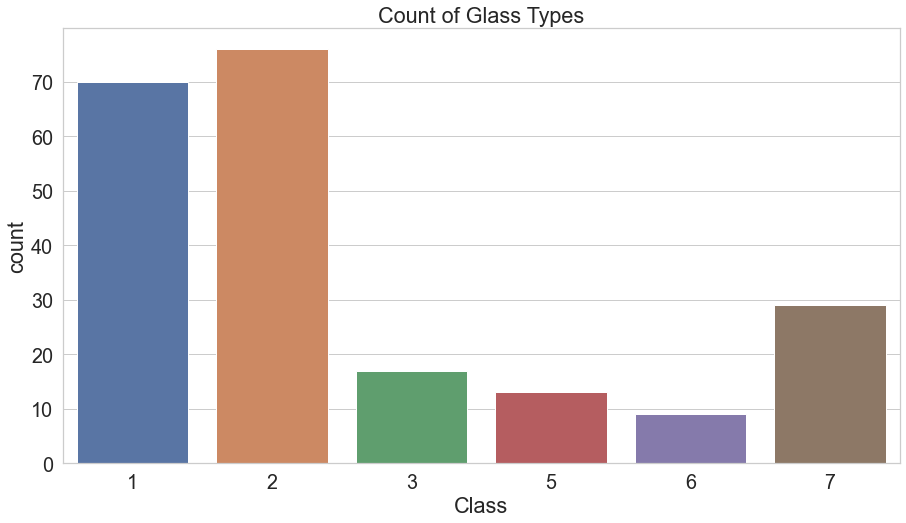

In [13]:
sns.set(style="whitegrid", font_scale=1.8)
plt.subplots(figsize = (15,8))
sns.countplot('Class',data=df).set_title('Count of Glass Types')
plt.show()

we can easily makeout that this data is not balanced 

### which is more balanced

In [14]:
for i in class_info.index:
    c = class_info[i]
    print(f'Class {i}, Count:{c}, Percentage:{round(c*100/214,3)}%')

Class 1, Count:70, Percentage:32.71%
Class 2, Count:76, Percentage:35.514%
Class 3, Count:17, Percentage:7.944%
Class 5, Count:13, Percentage:6.075%
Class 6, Count:9, Percentage:4.206%
Class 7, Count:29, Percentage:13.551%


In [15]:
# Checked both mean and median. mean seemed more informative
df.groupby('Class', as_index=False).mean()

,Class,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1,1.518718,13.242286,3.552429,1.163857,72.619143,0.447429,8.797286,0.012714,0.057000
1,2,1.518619,13.111711,3.002105,1.408158,72.598026,0.521053,9.073684,0.050263,0.079737
2,3,1.517964,13.437059,3.543529,1.201176,72.404706,0.406471,8.782941,0.008824,0.057059
3,5,1.518928,12.827692,0.773846,2.033846,72.366154,1.470000,10.123846,0.187692,0.060769
4,6,1.517456,14.646667,1.305556,1.366667,73.206667,0.000000,9.356667,0.000000,0.000000
5,7,1.517116,14.442069,0.538276,2.122759,72.965862,0.325172,8.491379,1.040000,0.013448


In [18]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.33,stratify=Y,random_state=1)

In [19]:
ss=StandardScaler()
le=LabelEncoder()
X = ss.fit_transform(X_train)
y = le.fit_transform(y_train)
X_test = ss.transform(X_test)
y_test = le.transform(y_test)
print("X,y shape:",X.shape,y.shape)

X,y shape: (143, 9) (143,)


In [20]:
def evaluate(X,y,estimator):
    cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=10)
    score = cross_val_score(estimator,X,y,scoring='accuracy',cv=cv)
    return score

### Baseline: 35% (Predicting class 2 for every sample)
### We'll now evaluate several models

In [21]:
lm = LogisticRegression(penalty='l2',solver='newton-cg')
svm = SVC(gamma='auto')
knn = KNeighborsClassifier()
dTree = DecisionTreeClassifier(max_depth=100)
weights = {0:1.0,1:1.0,2:2.0,3:2.0,4:2.0,5:2.0}
rf = RandomForestClassifier(n_estimators=1000,class_weight=weights)

models = {'Logistic Regression':lm,'SVM':svm,'KNN':knn,'Decision Tree':dTree,'Random Forest': rf}

results = []
print("Cross val average accuracy(without oversampling or hyperparameter tuning)")
for k,v in models.items():
    result = evaluate(X,y,v)
    results.append(result)
    print(f'{k}: {round(np.mean(result),3)}')

Cross val average accuracy(without oversampling or hyperparameter tuning)
Logistic Regression: 0.605
SVM: 0.646
KNN: 0.587
Decision Tree: 0.659
Random Forest: 0.749


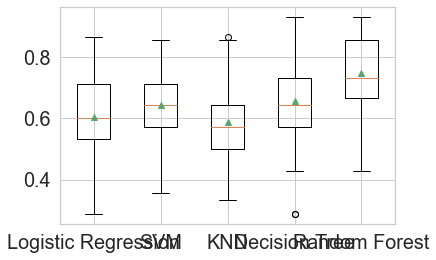

In [22]:
plt.boxplot(results,labels=models.keys(),showmeans=True)
plt.show()

Using SMOTE(Synthetic Minority Oversampling technique) Oversampling
Let's take a look again on what the class ditribution looks like

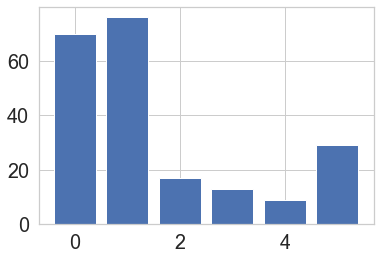

In [23]:
plt.bar(np.unique(y),class_info)
plt.show()

### Using SMOTE

In [25]:
X,y = SMOTE(sampling_strategy = {0:200, 1:200, 2:200, 3:200, 4:200, 5:200}).fit_resample(X,y)

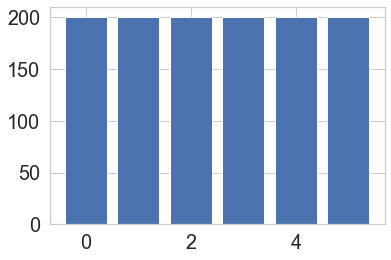

In [26]:
names,counts = np.unique(y,return_counts=True)
plt.bar(names,counts)
plt.show()

In [27]:
lm = LogisticRegression(penalty='l2',solver='newton-cg')
svm = SVC(gamma='auto')
knn = KNeighborsClassifier()
dTree = DecisionTreeClassifier(max_depth=100)
rf = RandomForestClassifier(n_estimators=1000,class_weight='balanced')

models = {'Logistic Regression':lm,'SVM':svm,'KNN':knn,'Decision Tree':dTree,'Random Forest': rf}

results = []
print("Cross val average accuracy on oversampled data(without hyperparameter tuning)")
for k,v in models.items():
    result = evaluate(X,y,v)
    results.append(result)
    print(f'{k}: {round(np.mean(result),3)}')

Cross val average accuracy on oversampled data(without hyperparameter tuning)
Logistic Regression: 0.88
SVM: 0.921
KNN: 0.96
Decision Tree: 0.946
Random Forest: 0.981


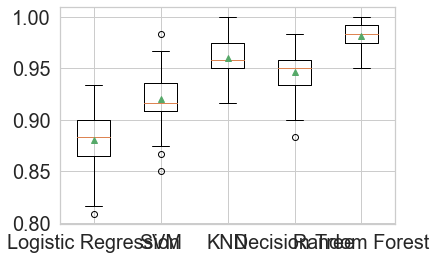

In [28]:
plt.boxplot(results,labels=models.keys(),showmeans=True)
plt.show()

### Hyperparameter Tuning

In [29]:
params = {'penalty':('l1', 'l2'),'tol':[1e-4,1e-3],'C':[1.0,3.0,5.0],
             'class_weight':('balanced',None),'solver':('newton-cg', 'lbfgs', 'liblinear'),'multi_class':('auto', 'ovr', 'multinomial')}
clf = GridSearchCV(LogisticRegression(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
lm_best = clf.best_estimator_
print("Logistic Regresion:")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Logistic Regresion:
Best Result: 0.8925000000000001
Best Param: {'C': 5.0, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001}


In [30]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10],'weights':('uniform','distance'),
             'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
         'p':[1,2,3,4]}
clf = GridSearchCV(KNeighborsClassifier(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
knn_best = clf.best_estimator_
print("KNN")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

KNN
Best Result: 0.9841666666666666
Best Param: {'algorithm': 'auto', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


In [31]:
params = {'C':[1.0,1.5,2.0,2.5,3.0,4.0,5.0],'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
             'gamma':('scale','auto'),'decision_function_shape':('ovo', 'ovr')}
clf = GridSearchCV(SVC(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
svm_best = clf.best_estimator_
print("SVM")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

SVM
Best Result: 0.9483333333333333
Best Param: {'C': 5.0, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf'}


In [32]:
params = {'criterion':('gini', 'entropy'),'splitter':('best', 'random'),'max_depth':[10,50,100,500,1000],
          'min_samples_split':[1,2,5,10],'min_samples_leaf':[1,2,3,5],'max_features':('auto','sqrt','log2',None)}
clf = GridSearchCV(DecisionTreeClassifier(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
dTree_best = clf.best_estimator_
print("Decision Tree")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Decision Tree
Best Result: 0.96
Best Param: {'criterion': 'entropy', 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}


In [33]:
params = {'n_estimators':[1,10,100,1000],'max_depth':[1,10,100,1000],
          'min_samples_split':[1,2],'min_samples_leaf':[1,2],
         'class_weight':('balanced', 'balanced_subsample',None)}
clf = GridSearchCV(RandomForestClassifier(),params,cv=5,scoring='accuracy')
clf.fit(X,y)
rf_best = clf.best_estimator_
print("Random Forest")
print('Best Result:',clf.best_score_)
print('Best Param:',clf.best_params_)

Random Forest
Best Result: 0.9833333333333334
Best Param: {'class_weight': 'balanced', 'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [34]:
models = {'Logistic Regression':lm_best,'SVM':svm_best,'KNN':knn_best,'Decision Tree':dTree_best,'Random Forest': rf_best}

results = []
print("Cross val average accuracy on oversampled data and hyperparameter tuned model")
for k,v in models.items():
    result = evaluate(X,y,v)
    results.append(result)
    print(f'{k}: {round(np.mean(result),3)}')

Cross val average accuracy on oversampled data and hyperparameter tuned model
Logistic Regression: 0.893
SVM: 0.946
KNN: 0.985
Decision Tree: 0.948
Random Forest: 0.982


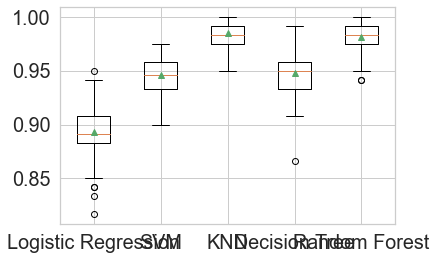

In [35]:
plt.boxplot(results,labels=models.keys(),showmeans=True)
plt.show()

In [36]:
models = {'Logistic Regression':lm_best,'SVM':svm_best,'KNN':knn_best,'Decision Tree':dTree_best,'Random Forest': rf_best}
results = []
print("Test set accuracy")
for k,v in models.items():
    v.fit(X,y)
    y_pred = v.predict(X_test)
    results.append(accuracy_score(y_test,y_pred))
    print(f'{k}: {round(accuracy_score(y_test,y_pred),3)}')

Test set accuracy
Logistic Regression: 0.676
SVM: 0.746
KNN: 0.789
Decision Tree: 0.704
Random Forest: 0.845


Overall test accuracy
Logistic Regression: 0.6761
SVM: 0.7465
KNN: 0.7887
Decision Tree: 0.7042
Random Forest: 0.8451


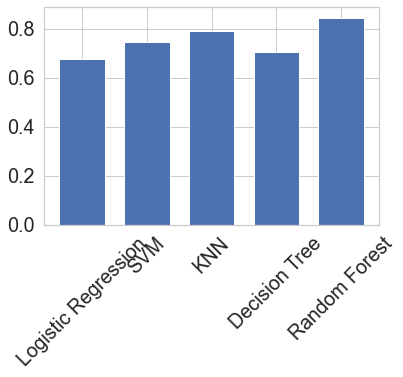

In [38]:
all_models = list(models.keys())

all_results = list(results)

print("Overall test accuracy")
for i,m in enumerate(all_models):
    print(f"{m}: {round(all_results[i],4)}")
plt.bar(all_models,all_results, align='center',width=0.7)
plt.xticks(rotation=45)
plt.show()

### AS HERE WE CAN EASILY MAKE A DECISION THAT RANDOM FOREST IS SHOWING EXCELLENT OVERALL ACCURECY AMONG ALL THE MACHINE LEARNING MODELS .
### SO OUR FINAL CHOICE OF MODEL WILL BE RANDOM FOREST

SAVING THE MODEL USING PIKLE[pickle.dump(model, open('model.pkl', 'wb'))]